# Shopping Cart Analysis with Neo4j

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

## Data preparation and ingestion

In [2]:
df = pd.read_csv('./data/dataset_group.csv', delimiter=',', names=['date', 'transaction', 'product'])
df.head()

,date,transaction,product
0,2000-01-01,1,yogurt
1,2000-01-01,1,pork
2,2000-01-01,1,sandwich bags
3,2000-01-01,1,lunch meat
4,2000-01-01,1,all- purpose


<AxesSubplot: >

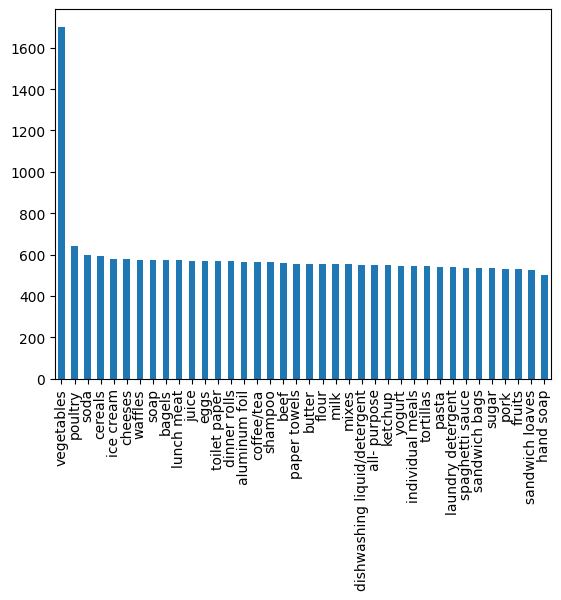

In [33]:
df['product'].value_counts().plot(kind="bar")

In [3]:
transactions = df.groupby(['transaction', 'date'])['product'].apply(list).reset_index(name='products')
transactions.head()

,transaction,date,products
0,1,2000-01-01,"[yogurt, pork, sandwich bags, lunch meat, all-..."
1,2,2000-01-01,"[toilet paper, shampoo, hand soap, waffles, ve..."
2,3,2000-01-02,"[soda, pork, soap, ice cream, toilet paper, di..."
3,4,2000-01-02,"[cereals, juice, lunch meat, soda, toilet pape..."
4,5,2000-01-02,"[sandwich loaves, pasta, tortillas, mixes, han..."


In [4]:
from neo4j import GraphDatabase

# Inspiration taken from: https://towardsdatascience.com/create-a-graph-database-in-neo4j-using-python-4172d40f89c4
class Neo4jConnection:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def print_greeting(self, message):
        with self.driver.session() as session:
            greeting = session.execute_write(self._create_and_return_greeting, message)
            print(greeting)
    
    def query(self, query, parameters=None, db=None):
        assert self.driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.driver.session(database=db) if db is not None else self.driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [5]:
conn = Neo4jConnection("bolt://localhost:7687", "neo4j", "!Random_Password1234")

In [6]:
# Create entities and apply unique constraints to avoid duplicates
conn.query('CREATE CONSTRAINT transactions IF NOT EXISTS ON (t:Transactions) ASSERT t.id IS UNIQUE')
conn.query('CREATE CONSTRAINT products IF NOT EXISTS ON (p:Products) ASSERT p.name IS UNIQUE')


[]

In [7]:
import time
def insert_data(query, rows, batch_size=10000):
    total = 0
    batch = 0
    start = time.time()
    result = None
        
    while batch * batch_size < len(rows):

        res = conn.query(query, 
                            parameters = {'rows': rows[batch*batch_size:(batch+1)*batch_size]})
        total += res[0]['total'] if len(res) > 0 else 0
        batch += 1
        result = {"total":total, 
                    "batches":batch, 
                    "time":time.time()-start}
        print(result)
            
    return result

def add_products(rows):
    query = '''
            UNWIND $rows AS row
            MERGE (:Products {name: row})
            RETURN count(*) as total
            '''
    return insert_data(query, rows)
    
def add_transactions(rows, batch_size=5000):
    query = '''
        UNWIND $rows as row
        MERGE (t:Transactions {id:row.transaction}) ON CREATE SET t.date = row.date
        
        WITH row, t
        UNWIND row.products AS product
        MATCH (p:Products {name: product})
        // connect products to transactions
        MERGE (p)-[:IN]->(t)
        // connect transactions to products
        MERGE (t)-[:CONTAINS]->(p)
        '''
        
    return insert_data(query, rows, batch_size)

In [8]:
products = df['product'].unique()
add_products(list(products))


{'total': 38, 'batches': 1, 'time': 0.021001100540161133}


{'total': 38, 'batches': 1, 'time': 0.021001100540161133}

In [9]:
transaction_transformed = transactions.to_dict(orient='records')
add_transactions(transaction_transformed)

{'total': 0, 'batches': 1, 'time': 0.29968810081481934}


{'total': 0, 'batches': 1, 'time': 0.29968810081481934}

In [10]:
conn.close()

In [49]:
# Calculate support as freq(i1, i2, ix)/N
def calc_support(conn: Neo4jConnection, products: list) -> float:
    """Calculate the support of the given products. Products that are not part of the DB will be ignored and support will only be calculated between remaining products

    Args:
        conn (Neo4jConnection): Connection object exposing a .query() method to be used as an interface to the Neo4j DB
        products (list): Names of products to be referenced

    Returns:
        float: support
    """
    query = f'''
        // freq
        WITH {products} as names
        MATCH (p:Products)
        WHERE p.name in names
        WITH collect(p) as products_searching
        MATCH (t:Transactions)
        WHERE ALL(p in products_searching WHERE (p)-[:IN]->(t)) with count(t) as freq

        // N
        MATCH (n:Transactions)

        // support
        RETURN toFloat(freq) / count(n) as support
    '''
    return conn.query(query)[0]['support']

calc_support(conn, ["milk", "yogurt", "pork"])

0.0649692712906058

In [51]:
def calc_confidence(conn: Neo4jConnection, product_a: str, product_b: str) -> float:
    """Calculates the confidence between two products as product_a => product_b

    Args:
        conn (Neo4jConnection): Connection object exposing a .query() method to be used as an interface to the Neo4j DB
        product_a (str): Product already purchased
        product_b (str): Dependentent product

    Returns:
        float: confidence
    """
    products = [product_a, product_b]
    return calc_support(conn, products) / calc_support(conn, [product_a])

calc_confidence(conn, "yogurt", "milk")

0.4360730593607306

In [52]:
def calc_lift(conn: Neo4jConnection, product_a: str, product_b: str) -> float:
    """Calculate the lift between two products as product_a => product_b

    Args:
        conn (Neo4jConnection): Connection object exposing a .query() method to be used as an interface to the Neo4j DB
        product_a (str): Product already purchased
        product_b (str): Dependentent product

    Returns:
        float: lift
    """
    return calc_support(conn, [product_a, product_b]) / (calc_support(conn, [product_a])/calc_support(conn, [product_b]))

calc_lift(conn, "yogurt", "milk")

0.16577667664898715

In [53]:
def calc_conviction(conn: Neo4jConnection, product_a: str, product_b: str) -> float:
    """Calculate the conviction between product_a and product_b as product_a => product_b

    Args:
        conn (Neo4jConnection): Connection object exposing a .query() method to be used as an interface to the Neo4j DB
        product_a (str): First product
        product_b (str): Second product

    Returns:
        float: conviction
    """
    return (1-calc_support(conn, [product_b]))/(1-calc_confidence(conn, product_a, product_b))

calc_conviction(conn, "yogurt", "milk")

1.0991529610817075